<a href="https://colab.research.google.com/github/RafGuiro/PojetoKNNTIC36/blob/main/ProjetoKnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das Bibliotecas Necessárias

In [ ]:
#Importações de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
import gdown

# Importar arquivo

In [ ]:
# Baixar e fazer upload do dataset
!gdown '1g-Qo-tITl6bDGJxNP2S-dyB28uKKrURa'

Downloading...
From: https://drive.google.com/uc?id=1g-Qo-tITl6bDGJxNP2S-dyB28uKKrURa
To: /content/top_insta_influencers_data.csv
100% 12.6k/12.6k [00:00<00:00, 23.4MB/s]


# Carregamento dos Dados

In [ ]:
# Definir o arquivo
url = "/content/top_insta_influencers_data.csv"
df = pd.read_csv(url)

print(df.head())

## Remover colunas desnecessárias ou com muitas informações textuais
df = df.drop(columns=['channel_info'])

## Lidar com valores NaN
df = df.dropna()  # Remover as linhas com valores ausentes

   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%            665.3k       12.5b  United States  


# Mapeamento dos Países

In [ ]:
# Definir listas de países por continente
south_america = ['Brazil', 'Argentina', 'Chile', 'Colombia', 'Peru', 'Ecuador', 'Venezuela', 'Bolivia']
north_america = ['United States', 'Canada', 'Mexico']
europe = ['United Kingdom', 'France', 'Germany', 'Italy', 'Spain', 'Netherlands', 'Sweden']
asia = ['India', 'China', 'Japan', 'South Korea', 'Indonesia', 'Pakistan', 'Bangladesh']
oceania = ['Australia', 'New Zealand', 'Fiji', 'Papua New Guinea']
africa = ['South Africa', 'Nigeria', 'Egypt', 'Kenya', 'Morocco', 'Ghana', 'Ethiopia']

# Mapear países para continentes
continente_map = {}
for country in south_america:
    continente_map[country] = 1  # América do Sul
for country in north_america:
    continente_map[country] = 20  # América do Norte
for country in europe:
    continente_map[country] = 40  # Europa
for country in asia:
    continente_map[country] = 50  # Ásia
for country in oceania:
    continente_map[country] = 60  # Oceania
for country in africa:
    continente_map[country] = 70  # África

# Adicionar países/territórios não mapeados
continente_map['Côte d\'Ivoire'] = 70  # África
continente_map['Anguilla'] = 20  # América do Norte
continente_map['Puerto Rico'] = 20  # América do Norte

# Aplicar o mapeamento no dataframe
df['country'] = df['country'].map(continente_map)
df['country'] = df['country'].fillna(df['country'].median())


# Função de converção de texto para Numeros

In [ ]:
# Função para converter valores de texto em números (k, m, b)
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.lower().replace(',', '')
        if 'm' in value:
            return float(value.replace('m', '').strip()) * 1e6
        elif 'k' in value:
            return float(value.replace('k', '').strip()) * 1e3
        elif 'b' in value:
            return float(value.replace('b', '').strip()) * 1e9
    return float(value) if pd.notna(value) else np.nan

# Converter colunas para números
df['followers'] = df['followers'].apply(convert_to_numeric)
df['total_likes'] = df['total_likes'].apply(convert_to_numeric)
df['avg_likes'] = df['avg_likes'].apply(convert_to_numeric)
df['new_post_avg_like'] = df['new_post_avg_like'].apply(convert_to_numeric)

# Converter a coluna de percentual '60_day_eng_rate' para número
df['60_day_eng_rate'] = df['60_day_eng_rate'].replace('%', '', regex=True).astype(float) / 100

# Normalização

In [ ]:
# Adicionar transformações logarítmicas
df['followers_log'] = np.log1p(df['followers'])
df['total_likes_log'] = np.log1p(df['total_likes'])

# Criar novos recursos
df['likes_per_follower'] = df['avg_likes'] / (df['followers_log'] + 1)
df['engagement_score'] = df['new_post_avg_like'] / (df['followers_log'] + 1)

# Seleção de variáveis e normalização
X = df[['followers_log', 'avg_likes', '60_day_eng_rate', 'total_likes_log', 'country', 'likes_per_follower', 'engagement_score']]
y = df['influence_score']

# Escalonamento com StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balanceamento

In [ ]:
# Balanceamento e remoção de outliers com Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
yhat = iso.fit_predict(X_scaled)
mask = yhat != -1
X_scaled, y = X_scaled[mask], y[mask]

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Implementação do KNN

In [ ]:
# Implementação e otimização do kNN
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros:", grid_search.best_params_)


Melhores hiperparâmetros: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


# Métricas

In [ ]:
# Avaliação do modelo com os melhores hiperparâmetros
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

# Métricas de Avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 2.8069948661504642
MSE: 13.829795004405504
RMSE: 3.7188432347176863
R²: 0.28507158146279854


Países não mapeados: Empty DataFrame
Columns: [country]
Index: []


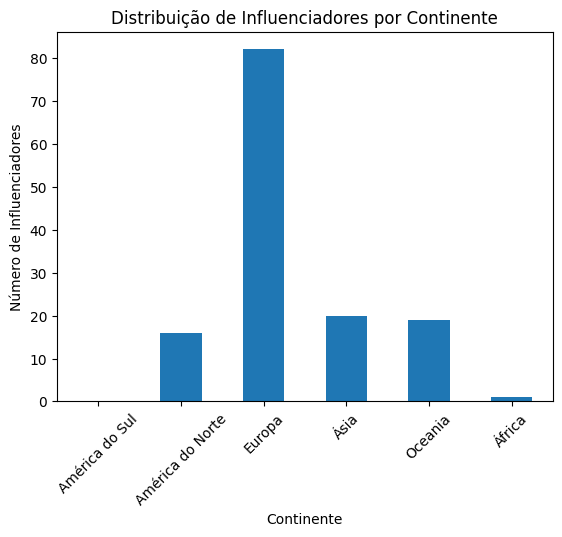

In [ ]:
# Verificar países não mapeados
countries_not_mapped = df[df['country'] == -1]
print("Países não mapeados:", countries_not_mapped[['country']].drop_duplicates())

# Contagem de influenciadores por continente, incluindo a categoria 'Outros' para valores não mapeados
continent_counts = df['country'].value_counts()

# Adicionar a categoria 'Outros' para os países não mapeados
continent_counts.loc[-1] = countries_not_mapped.shape[0]
continent_counts = continent_counts.sort_index()

# Plotar a distribuição por continente
continent_counts.plot(kind='bar')
plt.title("Distribuição de Influenciadores por Continente")
plt.xlabel("Continente")
plt.ylabel("Número de Influenciadores")

# Definir rótulos de forma dinâmica para garantir que eles correspondam ao número de categorias
continent_labels = ["América do Sul", "América do Norte", "Europa", "Ásia", "Oceania", "África", "Outros"]
plt.xticks(ticks=range(len(continent_counts)), labels=continent_labels[:len(continent_counts)], rotation=45)

plt.show()


## Gráfico de Followers vs Influence Score

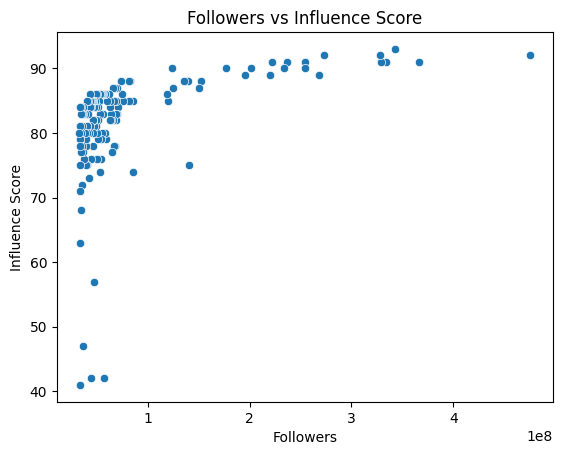

In [ ]:
sns.scatterplot(x=df['followers'], y=df['influence_score'])
plt.title("Followers vs Influence Score")
plt.xlabel("Followers")
plt.ylabel("Influence Score")
plt.show()

## Gráfico de Avg Likes vs Influence Score

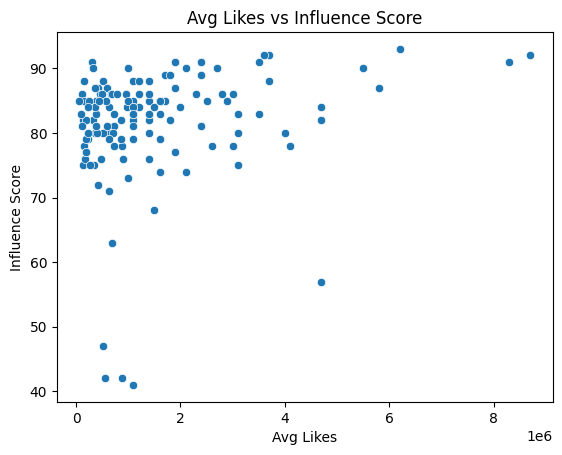

In [ ]:
sns.scatterplot(x=df['avg_likes'], y=df['influence_score'])
plt.title("Avg Likes vs Influence Score")
plt.xlabel("Avg Likes")
plt.ylabel("Influence Score")
plt.show()

## Gráfico de Followers vs Avg Likes

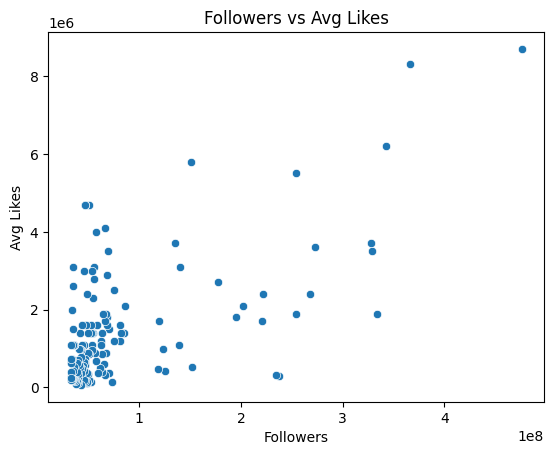

In [ ]:
sns.scatterplot(x=df['followers'], y=df['avg_likes'])
plt.title("Followers vs Avg Likes")
plt.xlabel("Followers")
plt.ylabel("Avg Likes")
plt.show()

## Gráfico de 60 Day Engagement Rate vs Influence Score

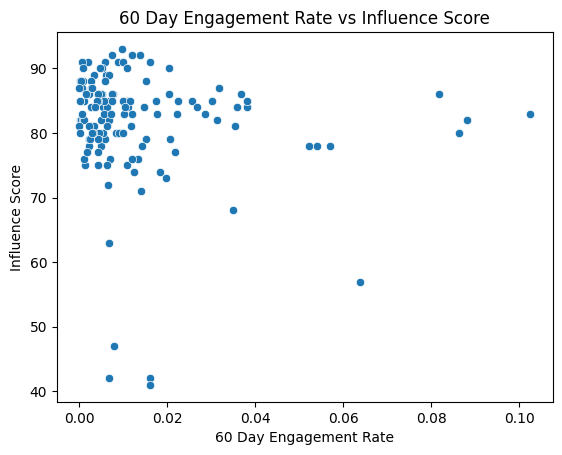

In [ ]:
sns.scatterplot(x=df['60_day_eng_rate'], y=df['influence_score'])
plt.title("60 Day Engagement Rate vs Influence Score")
plt.xlabel("60 Day Engagement Rate")
plt.ylabel("Influence Score")
plt.show()

## Gráfico de Total Likes vs Influence Score

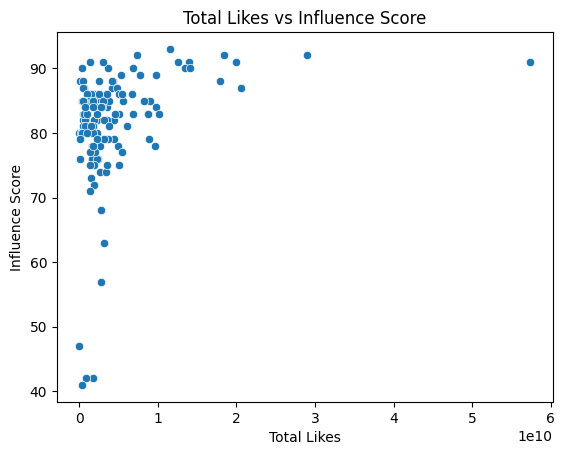

In [ ]:
sns.scatterplot(x=df['total_likes'], y=df['influence_score'])
plt.title("Total Likes vs Influence Score")
plt.xlabel("Total Likes")
plt.ylabel("Influence Score")
plt.show()

## Gráfico de New Post Avg Likes vs Influence Score

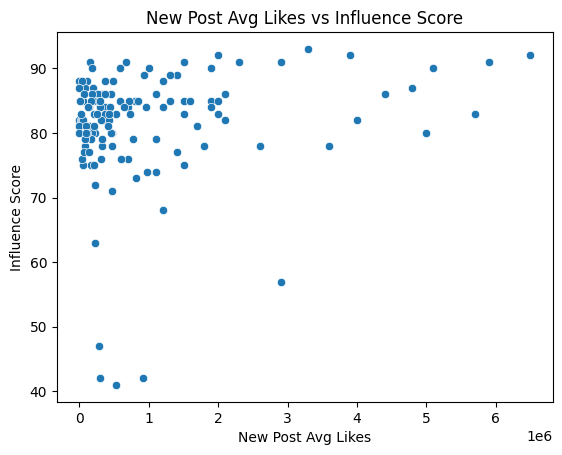

In [ ]:
sns.scatterplot(x=df['new_post_avg_like'], y=df['influence_score'])
plt.title("New Post Avg Likes vs Influence Score")
plt.xlabel("New Post Avg Likes")
plt.ylabel("Influence Score")
plt.show()

## Grafico de rank vs Influence_score

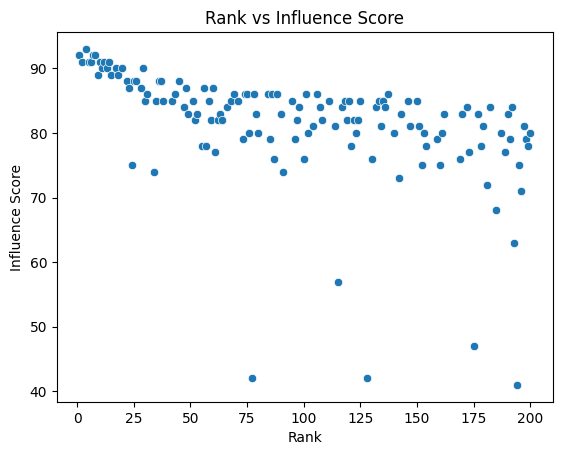

In [ ]:
sns.scatterplot(x=df['rank'], y=df['influence_score'])
plt.title("Rank vs Influence Score")
plt.xlabel("Rank")
plt.ylabel("Influence Score")
plt.show()

## Todos gráficos

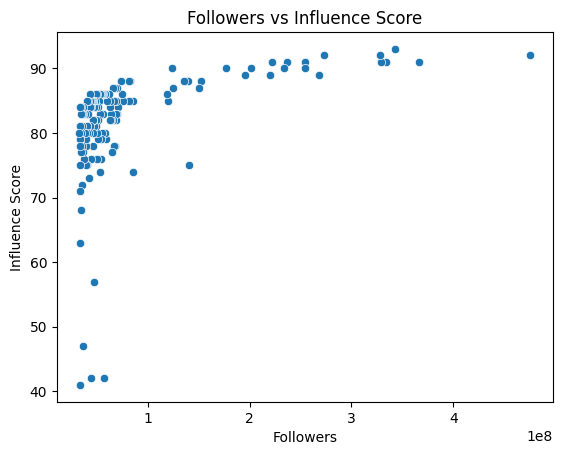

-------------------------------------------------------------------


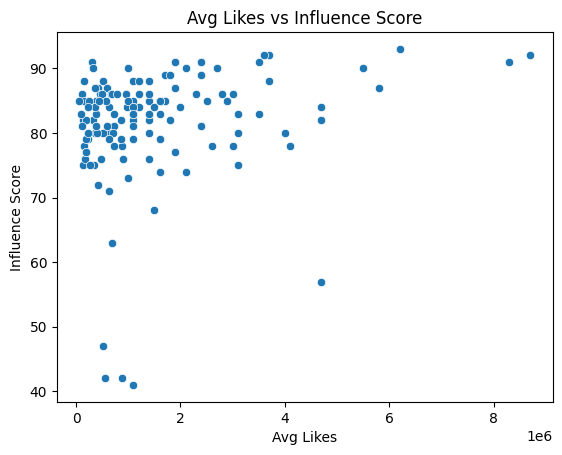

-------------------------------------------------------------------


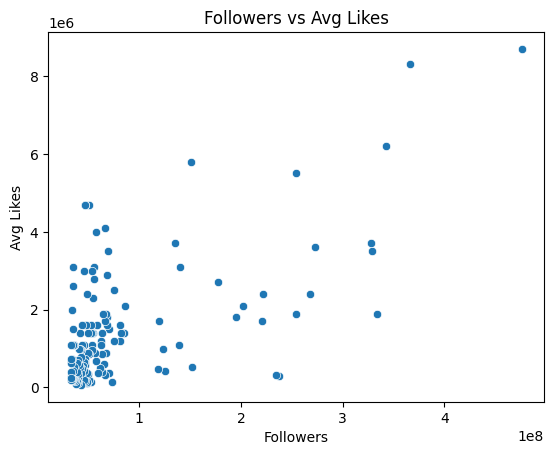

-------------------------------------------------------------------


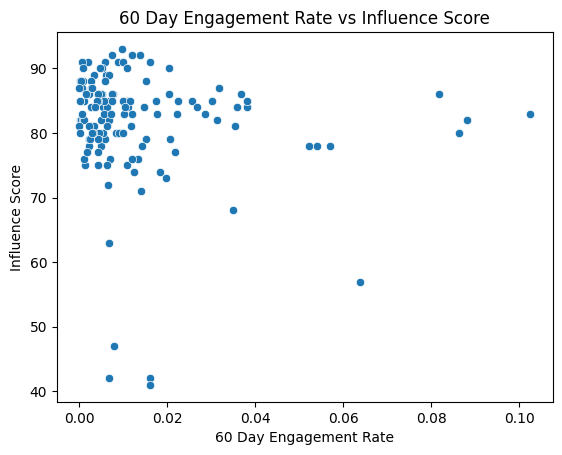

-------------------------------------------------------------------


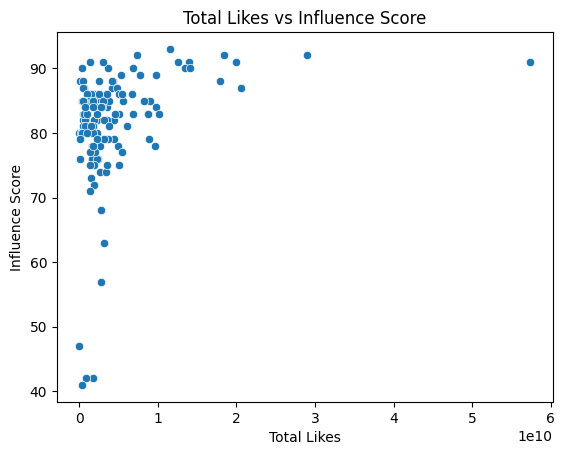

-------------------------------------------------------------------


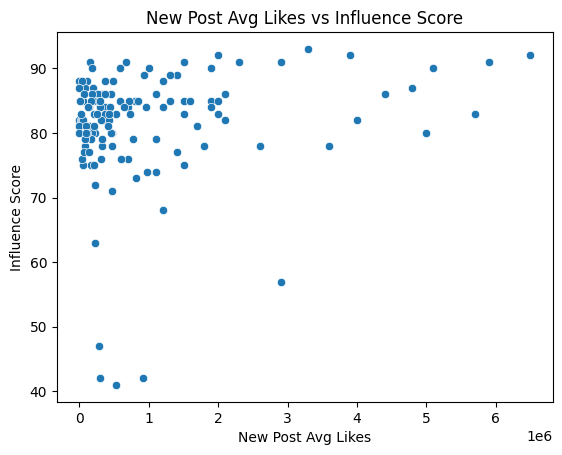

-------------------------------------------------------------------


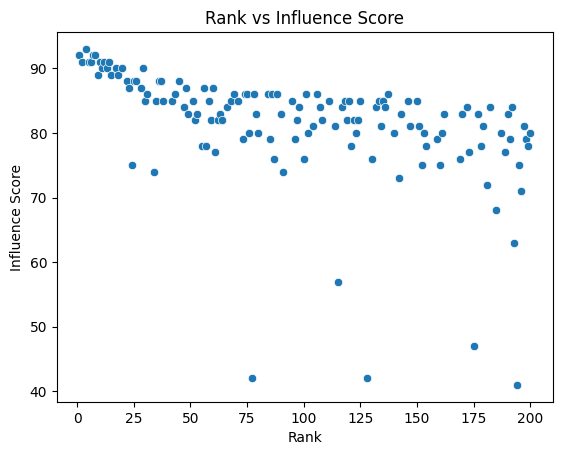

In [ ]:
sep = "-------------------------------------------------------------------"
# Gráfico de Followers vs Influence Score
sns.scatterplot(x=df['followers'], y=df['influence_score'])
plt.title("Followers vs Influence Score")
plt.xlabel("Followers")
plt.ylabel("Influence Score")
plt.show()

print(sep)

# Gráfico de Avg Likes vs Influence Score
sns.scatterplot(x=df['avg_likes'], y=df['influence_score'])
plt.title("Avg Likes vs Influence Score")
plt.xlabel("Avg Likes")
plt.ylabel("Influence Score")
plt.show()

print(sep)

# Gráfico de Followers vs Avg Likes
sns.scatterplot(x=df['followers'], y=df['avg_likes'])
plt.title("Followers vs Avg Likes")
plt.xlabel("Followers")
plt.ylabel("Avg Likes")
plt.show()

print(sep)

# Gráfico de 60 Day Engagement Rate vs Influence Score
sns.scatterplot(x=df['60_day_eng_rate'], y=df['influence_score'])
plt.title("60 Day Engagement Rate vs Influence Score")
plt.xlabel("60 Day Engagement Rate")
plt.ylabel("Influence Score")
plt.show()

print(sep)

# Gráfico de Total Likes vs Influence Score
sns.scatterplot(x=df['total_likes'], y=df['influence_score'])
plt.title("Total Likes vs Influence Score")
plt.xlabel("Total Likes")
plt.ylabel("Influence Score")
plt.show()

print(sep)

# Gráfico de New Post Avg Likes vs Influence Score
sns.scatterplot(x=df['new_post_avg_like'], y=df['influence_score'])
plt.title("New Post Avg Likes vs Influence Score")
plt.xlabel("New Post Avg Likes")
plt.ylabel("Influence Score")
plt.show()

print(sep)

#Grafico de rank vs Influence_score
sns.scatterplot(x=df['rank'], y=df['influence_score'])
plt.title("Rank vs Influence Score")
plt.xlabel("Rank")
plt.ylabel("Influence Score")
plt.show()

FacetGrid = sns.FacetGrid(df, col='country', col_wrap=3)
FacetGrid.map(sns.scatterplot, 'followers', 'influence_score')